In [ ]:
# Import Relevant Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Linear Interpolation
from scipy.interpolate import interp1d
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Forecasting Natural Gas Market Price

Objective: The objective is to enhance the granularity of available market data by extrapolating external feeds while accounting for seasonal price trends, enabling accurate pricing of natural gas storage contracts through historical analysis and future price estimation.

Task: Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 

Notes about the data: 
* Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.

In [8]:
# Load the CSV file containg the price of gas by month

Nat_Gas_df = pd.read_csv('Nat_Gas.csv')

## Quick EDA

In [9]:
# Quick snapshot of the first 5 months
Nat_Gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


C:\Users\chiar\AppData\Local\Temp\ipykernel_2860\1860891542.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=Nat_Gas_df['Dates'].min(),


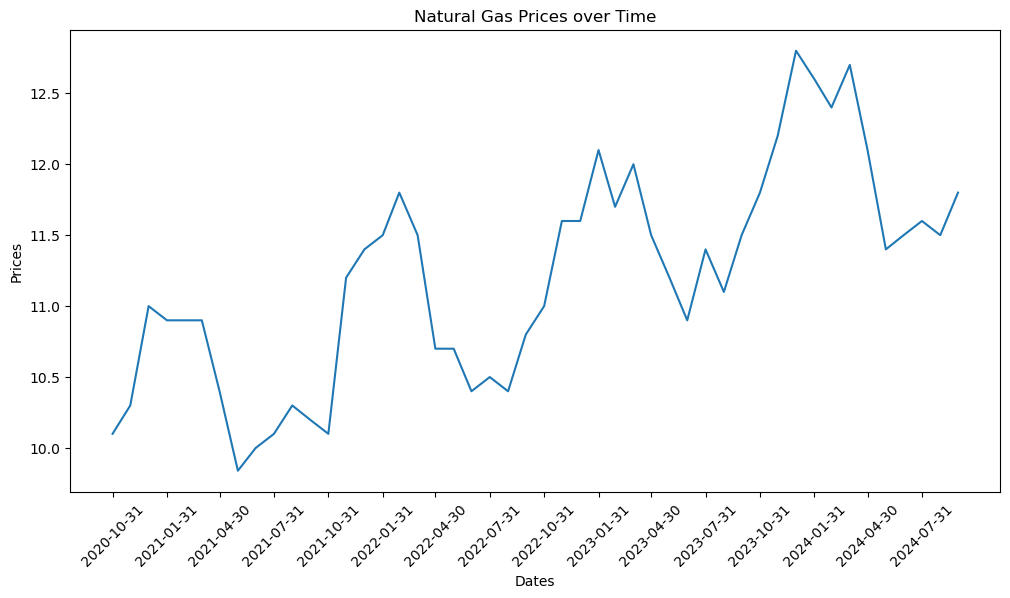

In [ ]:
# Visualizing the data
Nat_Gas_df['Dates'] = pd.to_datetime(Nat_Gas_df['Dates'])

plt.figure(figsize=(12, 6))
plt.plot(Nat_Gas_df['Dates'], Nat_Gas_df['Prices'], label="Natural Gas Prices")

# Formating the x-axis for every 3 months (or quarter)
plt.xticks(pd.date_range(start=Nat_Gas_df['Dates'].min(), 
                         end=Nat_Gas_df['Dates'].max(), 
                         freq='3M'), rotation=45)

# Labels and title
plt.title('Natural Gas Prices over Time')
plt.xlabel('Dates')
plt.ylabel('Prices')

# Show the plot
plt.show()


We first identify any trends and seasonality.

### We start with calculating a 3 month moving average for trends

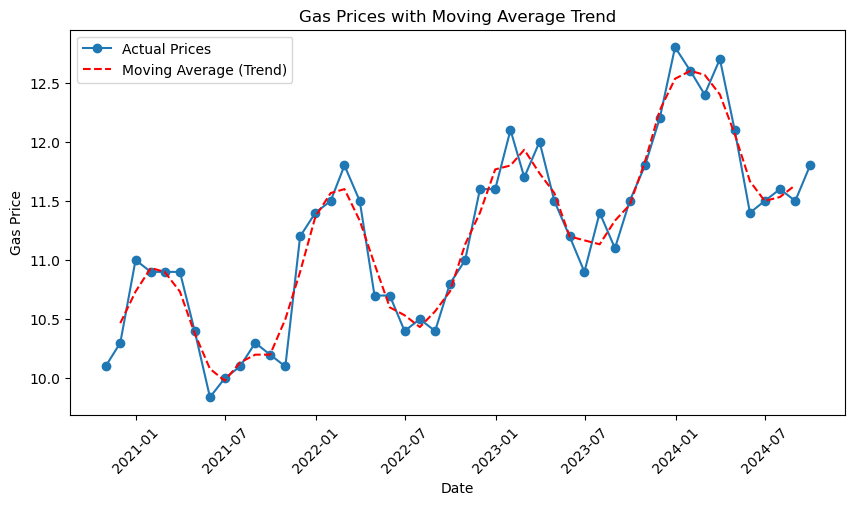

In [14]:
# Calculate Moving Average
Nat_Gas_df["RollingMean"] = Nat_Gas_df["Prices"].rolling(window=3, center=True).mean()  # 3-month moving average

# Plot
plt.figure(figsize=(10, 5))
plt.plot(Nat_Gas_df["Dates"], Nat_Gas_df["Prices"], marker="o", label="Actual Prices", linestyle="-")
plt.plot(Nat_Gas_df["Dates"], Nat_Gas_df["RollingMean"], label="Moving Average (Trend)", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Gas Price")
plt.title("Gas Prices with Moving Average Trend")
plt.legend()
plt.xticks(rotation=45)
plt.show()

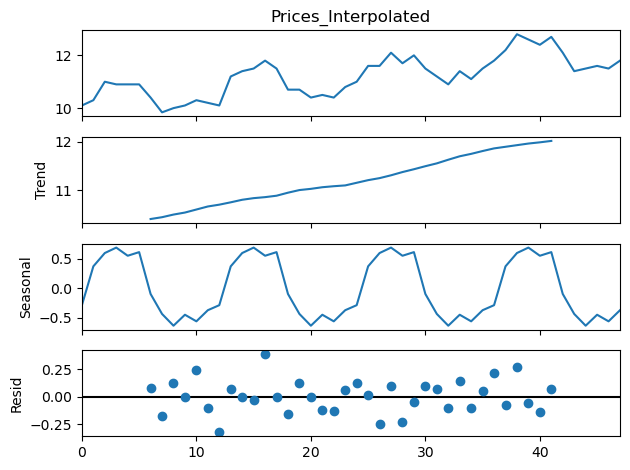

In [ ]:
# Use seasonal decomposition to extract trend and seasonality
# Interpolate missing values for decomposition
Nat_Gas_df["Prices_Interpolated"] = Nat_Gas_df["Prices"].interpolate()

# Decomposition
decomposition = seasonal_decompose(Nat_Gas_df["Prices_Interpolated"], model="additive", period=12)

decomposition.plot()
plt.show()

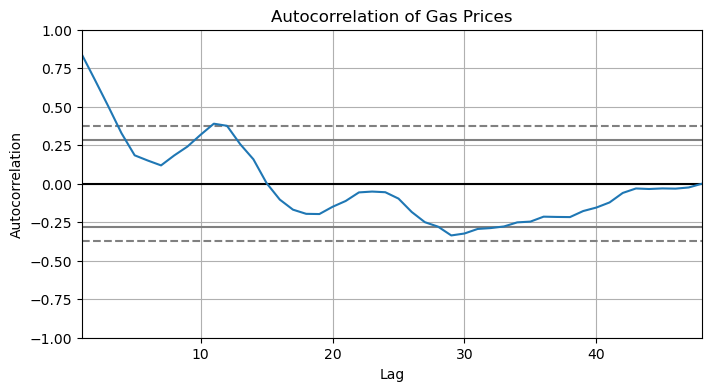

In [ ]:
plt.figure(figsize=(8, 4))
autocorrelation_plot(Nat_Gas_df["Prices"])
plt.title("Autocorrelation of Gas Prices")
plt.show()

We see from the above plots that there is evidence of seasonality, but it appears to be weak or irregular rather than a strong repeating yearly pattern. The autocorrelation function (ACF) does not exhibit clear periodic spikes at lags corresponding to annual cycles (e.g., 12, 24 months), suggesting that any seasonal effects may be subtle or influenced by external factors such as market conditions or policy changes. Additionally, the slow decay in ACF indicates a strong trend component, meaning past values continue to impact future prices over a long period. Given these findings, we may need to apply seasonal decomposition techniques or a seasonal ARIMA (SARIMA) model to better capture both trend and potential seasonal fluctuations in gas prices.

Moving forward, the first task is to estimate the price at any date. Therefore, we start with linear interpolation.

## 1. Linear Interpolation

In [24]:
Nat_Gas_df["Dates"] = pd.to_datetime(Nat_Gas_df["Dates"])
Nat_Gas_df["TimeIndex"] = (Nat_Gas_df["Dates"] - Nat_Gas_df["Dates"].min()).dt.days  # Convert dates to numerical index

# Create an interpolation function
interp_func = interp1d(Nat_Gas_df["TimeIndex"], Nat_Gas_df["Prices"], kind='linear', fill_value="extrapolate")

# Estimate price for a specific date
specific_date = "01/15/21"
specific_time_index = (pd.to_datetime(specific_date) - Nat_Gas_df["Dates"].min()).days
estimated_price = interp_func(specific_time_index)

print(f"Estimated Price on {specific_date}: {estimated_price:.2f}")

Estimated Price on 01/15/21: 10.95


## 2. Extrapolate for 1 year

In [26]:
# Calculate the time index for one year into the future
one_year_ahead = Nat_Gas_df["Dates"].max() + pd.DateOffset(months=12)
future_time_index = (one_year_ahead - Nat_Gas_df["Dates"].min()).days

# Extrapolate the price for the future date
extrapolated_price = interp_func(future_time_index)

print(f"Extrapolated Price for {one_year_ahead.date()}: {extrapolated_price:.2f}")

Extrapolated Price for 2025-09-30: 15.45


Next, we forecast the next year by fitting a Seasonal ARIMA model. This is to account for the trend and seasonality. For a quick review of SARIMA:

- Fit SARIMA model (p, d, q) x (P, D, Q, s)
- (p, d, q) are the non-seasonal parameters (AR, I, MA)
- P, D, Q, s) are the seasonal parameters
- s = seasonal period (12 for monthly data with yearly seasonality)

C:\Users\chiar\AppData\Local\Temp\ipykernel_2860\2515630760.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Nat_Gas_df["Dates"] = pd.to_datetime(Nat_Gas_df["Dates"])
c:\Users\chiar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\chiar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\chiar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting

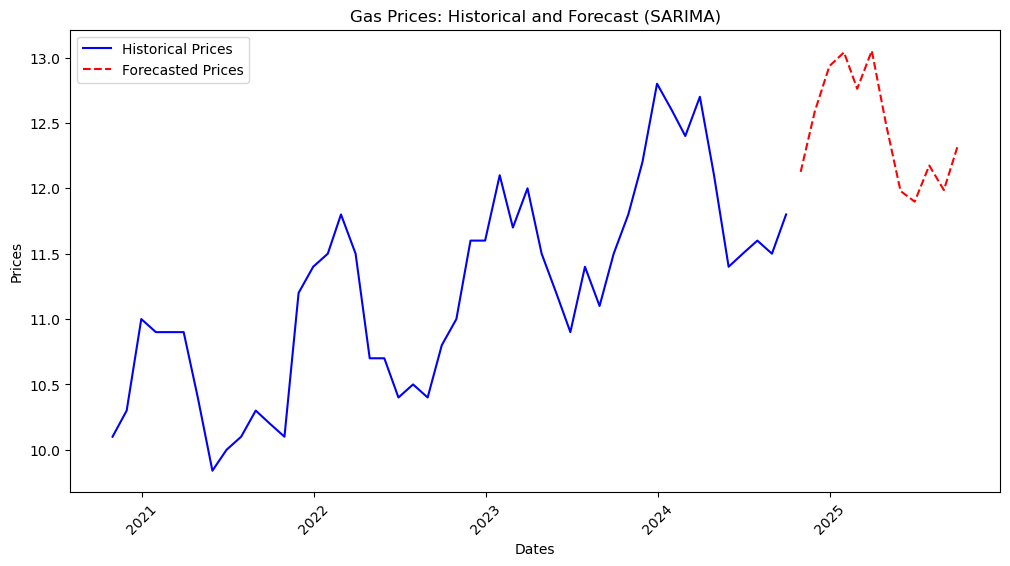

Forecasted Prices for the Next 12 Months (SARIMA):
2024-10-31    12.125723
2024-11-30    12.588711
2024-12-31    12.934792
2025-01-31    13.039962
2025-02-28    12.761522
2025-03-31    13.052298
2025-04-30    12.494462
2025-05-31    11.979337
2025-06-30    11.898213
2025-07-31    12.174310
2025-08-31    11.986365
2025-09-30    12.331532
Freq: ME, Name: predicted_mean, dtype: float64


In [ ]:
# Reload dataset
Nat_Gas_df = pd.read_csv('Nat_Gas.csv')

# have the dates be a datetime 
Nat_Gas_df["Dates"] = pd.to_datetime(Nat_Gas_df["Dates"])
Nat_Gas_df.set_index("Dates", inplace=True)

# Initializing the SARIMA model
model = SARIMAX(Nat_Gas_df['Prices'], 
                order=(1, 1, 1),        # Non-seasonal parameters (AR=1, I=1, MA=1)
                seasonal_order=(1, 1, 1, 12),  # Seasonal parameters (AR=1, I=1, MA=1, period=12 months)
                enforce_stationarity=False, 
                enforce_invertibility=False)

# Fitting the model
fitted_model = model.fit(disp=False)

# Forecast for the next 12 months (1 year ahead)
forecast_periods = 12
forecast = fitted_model.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(Nat_Gas_df.index[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_values = forecast.predicted_mean

# Plot historical prices and the forecasted future prices
plt.figure(figsize=(12, 6))
plt.plot(Nat_Gas_df.index, Nat_Gas_df['Prices'], label='Historical Prices', color="blue")
plt.plot(forecast_index, forecast_values, label='Forecasted Prices', linestyle='--', color="red")
plt.title('Gas Prices: Historical and Forecast (SARIMA)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print forecasted prices
print("Forecasted Prices for the Next 12 Months (SARIMA):")
print(forecast_values)


# Conclusion

The SARIMA model has been successfully applied to forecast the natural gas prices for the next 12 months. The forecasted prices indicate a gradual increase over the next few months, with some fluctuations along the way. 

- Starting at $12.13 in October 2024, the price is expected to rise steadily, reaching $13.04 by January 2025. 
- After peaking in early 2025, the forecast shows some correction, with prices declining slightly to $11.98 by August 2025, before increasing again to $12.33 in September 2025.

These fluctuations may reflect seasonal trends and market dynamics that influence gas prices on a yearly basis. The model captures both seasonality and trend, which are important for understanding price movements in the natural gas market. 

As with any model, it is essential to remember that these forecasts are based on historical data and assumptions about future trends, and the actual prices may vary depending on external factors such as geopolitical events, economic conditions, and energy supply fluctuations.

Overall, the SARIMA model provides a reasonable estimate for planning and analysis, but ongoing adjustments and real-time data would be necessary for more accurate predictions.